_____
_____
## Описание

**Анализ данных интернет-магазина, который продает компьютерные игры**

- Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). 
- Цель исследования: yужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

_____
_____
## Импорт и подготовка к работе

In [1]:
# %pip install missingno==0.5.2
# %pip install numpy==1.26.4
# %pip install pandas==2.2.2
# %pip install plotly==5.24.0
# %pip install scipy==1.14.1

In [2]:
import numpy as np
import pandas as pd
import missingno as msno
from scipy import stats as st
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

pd.set_option('display.max_columns', None)

_____
_____
## Загрузка данных и общая информация

_____
### Скачивание датасета

In [3]:
games = pd.read_csv('games.csv')
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


_____
### Информация о датасете

In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


|Поле             |Описание                                             |
|-----------------|-----------------------------------------------------|
|Name             |название игры                                        |
|Platform         |платформа                                            |
|Year_of_Release  |год выпуска                                          |
|Genre            |жанр игры                                            |
|NA_sales         |продажи в Северной Америке (миллионы проданных копий)|
|EU_sales         |продажи в Европе (миллионы проданных копий)          |
|JP_sales         |продажи в Японии (миллионы проданных копий)          |
|Other_sales      |продажи в других странах (миллионы проданных копий)  |
|Critic_Score     |оценка критиков (максимум 100)                       |
|User_Score       |оценка пользователей (максимум 10)                   |
|Rating           |возрастная категория                                 |

_____
### Вывод:

- Датасет содержит 16715 записей
- Колонки названы не корректно
- Фичи имеют разные типы данных, как числовые, так и категориальные
- В 6 из 11 столбцах есть пропуски

_____
_____
## Предобработка данных

_____
### Переименовывание столбцов датафрейма

In [5]:
games.columns = games.columns.str.lower()
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


_____
### Общая обработка датасета

- В колонке `year_of_release` есть значения "tbd", что рассшифровывается как "to be determined" (будет определено позже). Заменим эти значения на None

In [6]:
games.user_score.unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [7]:
games.user_score= games.user_score.replace('tbd', None)
games.user_score = pd.to_numeric(games.user_score)

- Для удобства работы переведем диапазон `critic_score` с [0; 100] до [0; 10]

Это упростит сравнение значений между `user_score` и `critic_score`

In [8]:
games.critic_score = games.critic_score / 10 

- Создадим столбец с общими продажами

In [9]:
games['sales'] = games.na_sales + games.eu_sales + games.jp_sales

_____
### Обработка дубликатов

Дубликатами можно считать игры, названия, платформа и год выпуска которых совпадают. Это обусловлено тем что игра с одним названием может выйти на разных платформах и быть переиздана в разные года.

In [10]:
print('Было', games.shape[0])
games = games.drop_duplicates(subset=['name', 'platform', 'year_of_release'])
print('Стало', games.shape[0])

Было 16715
Стало 16713


Ну пускай даже 2 строки.

_____
### Обработка пропушенных значений

#### Количество пропущенных в каждом столбце

,count missing,missing %
user_score,9124,54.592234
critic_score,8577,51.319332
rating,6765,40.477473
year_of_release,269,1.609526
name,1,0.005983
genre,1,0.005983
platform,0,0.000000
na_sales,0,0.000000
eu_sales,0,0.000000
jp_sales,0,0.000000


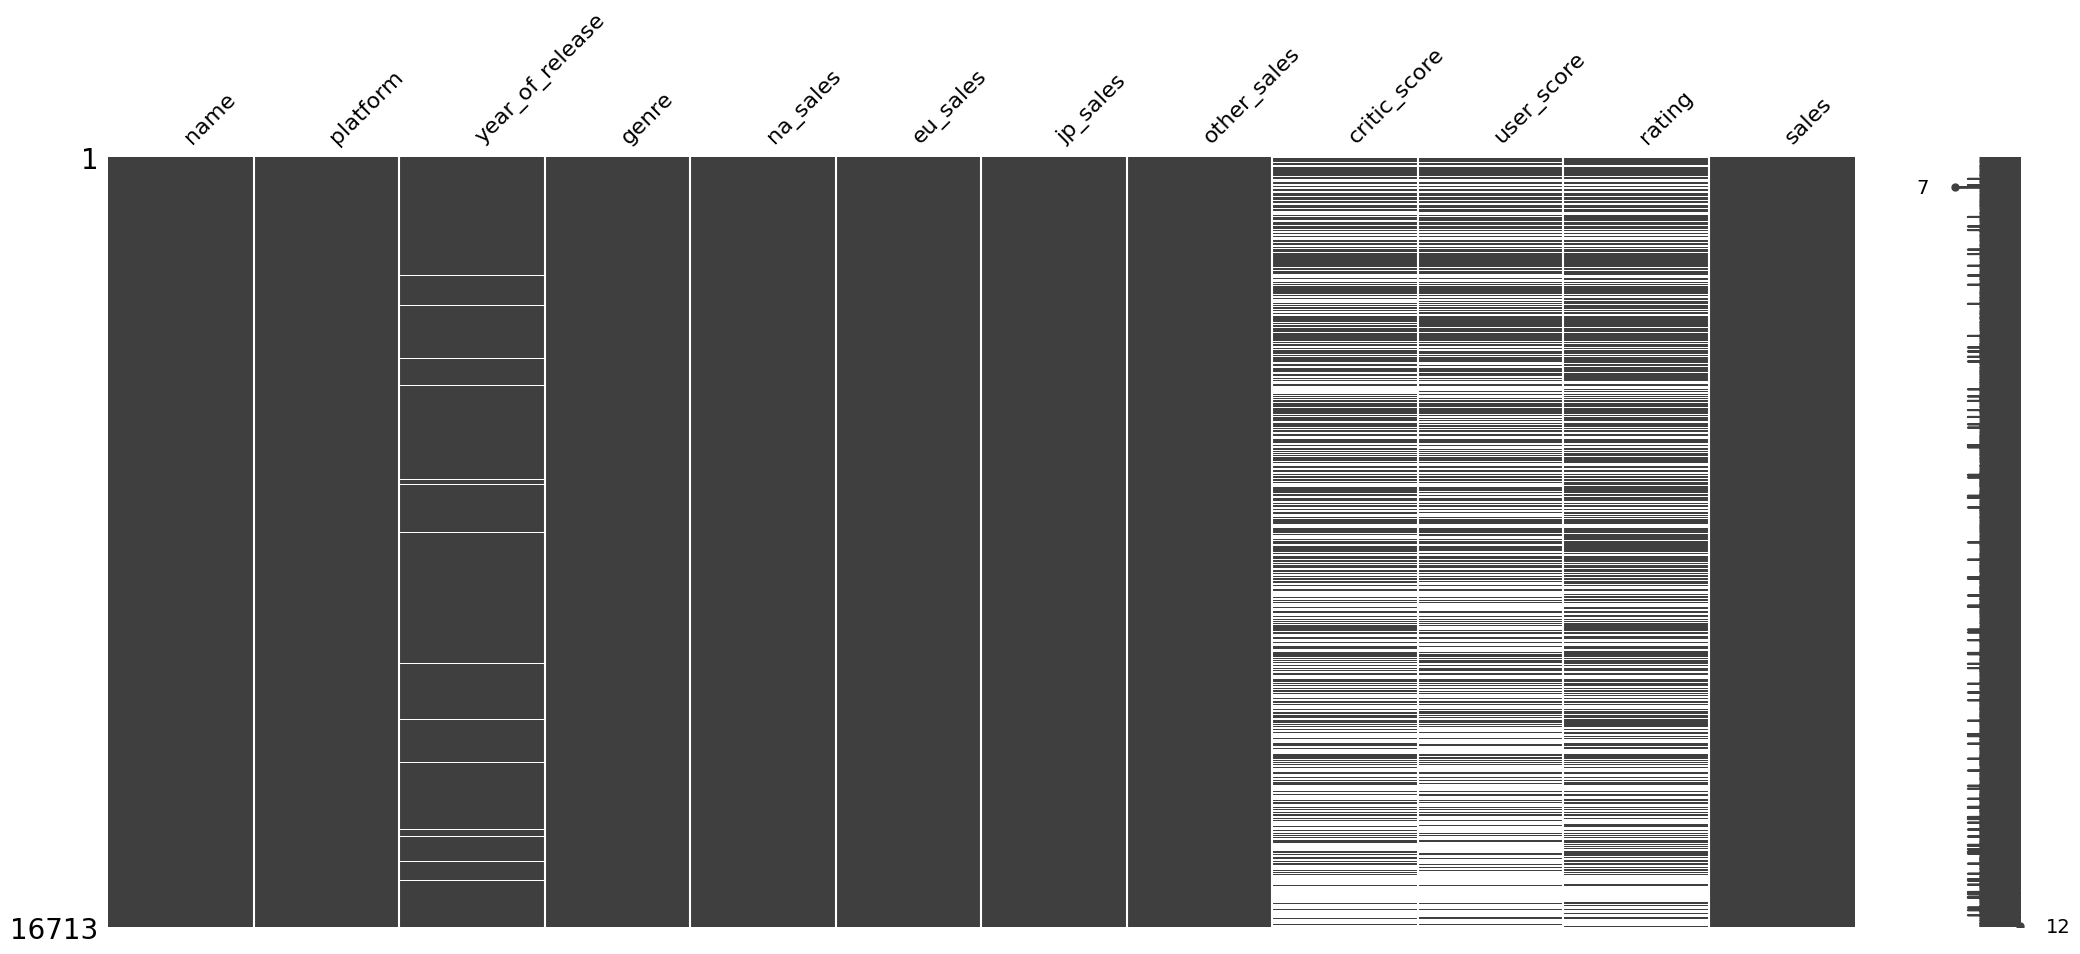

In [11]:
msno.matrix(games)

display(pd.DataFrame({
    'count missing': games.isna().sum().sort_values(ascending=False),
    'missing %': games.isna().mean().sort_values(ascending=False) * 100,
}).style.background_gradient('coolwarm'))

В датасете много пропусков, однако видно, что некоторую часть заполнить точно можно.

#### `year_of_release`, `genre`, `name`

Кол-во пропещнный в этих столбцах очень мало, поэтому можно просто дропнуть эти строки.

In [12]:
games = games.dropna(subset=['year_of_release', 'genre', 'name'])

#### `critic_score`, `user_score`

По матрице пропущенных значений видно, что пропуски в этих столбцах чаще всего одновременно, однако есть "xor" пропуски.

In [13]:
print('Корреляция между user_score и critic_score равна', games.user_score.corr(games.critic_score))
px.scatter_matrix(
    games,
    dimensions=['user_score', 'critic_score'],
    opacity=0.2,
    height=400,
    width=400
)

Корреляция между user_score и critic_score равна 0.5799197898468784


Значение корреляции умеренное, будет вполне валидно заполним "xor" пропуски значениями "другого" столбца.

In [14]:
games.user_score = games.user_score.fillna(games.critic_score)
games.critic_score = games.critic_score.fillna(games.user_score)
games.critic_score.isna().sum()

7892

На этом закончим, потому что оставшихся пропущенных значений слишком много и заполнять медианной, средним будет невалидно.

_____
### Приведение типов данных

In [15]:
games.dtypes
games.year_of_release = games.year_of_release.astype('uint16')
display(games.dtypes)

name                object
platform            object
year_of_release     uint16
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float64
rating              object
sales              float64
dtype: object

_____
### Обработка аномальных значений

In [16]:
fig = make_subplots(rows=3, cols=3, subplot_titles=games.select_dtypes(include=['number']).columns)

for i, column in enumerate(games.select_dtypes(include=['number']).columns):
    fig.add_trace(
        go.Box(y=games[column], name=column,),
        row=(i // 3) + 1, col=(i % 3) + 1
    )
fig.update_layout(height=1500, width=1200, showlegend=False)

Хоть математически в данных присутствуют выбросы, мы не будем их удалять, потому что все эти значения покажут истинную статистику. 

_____
### Вывод: 

<Axes: >

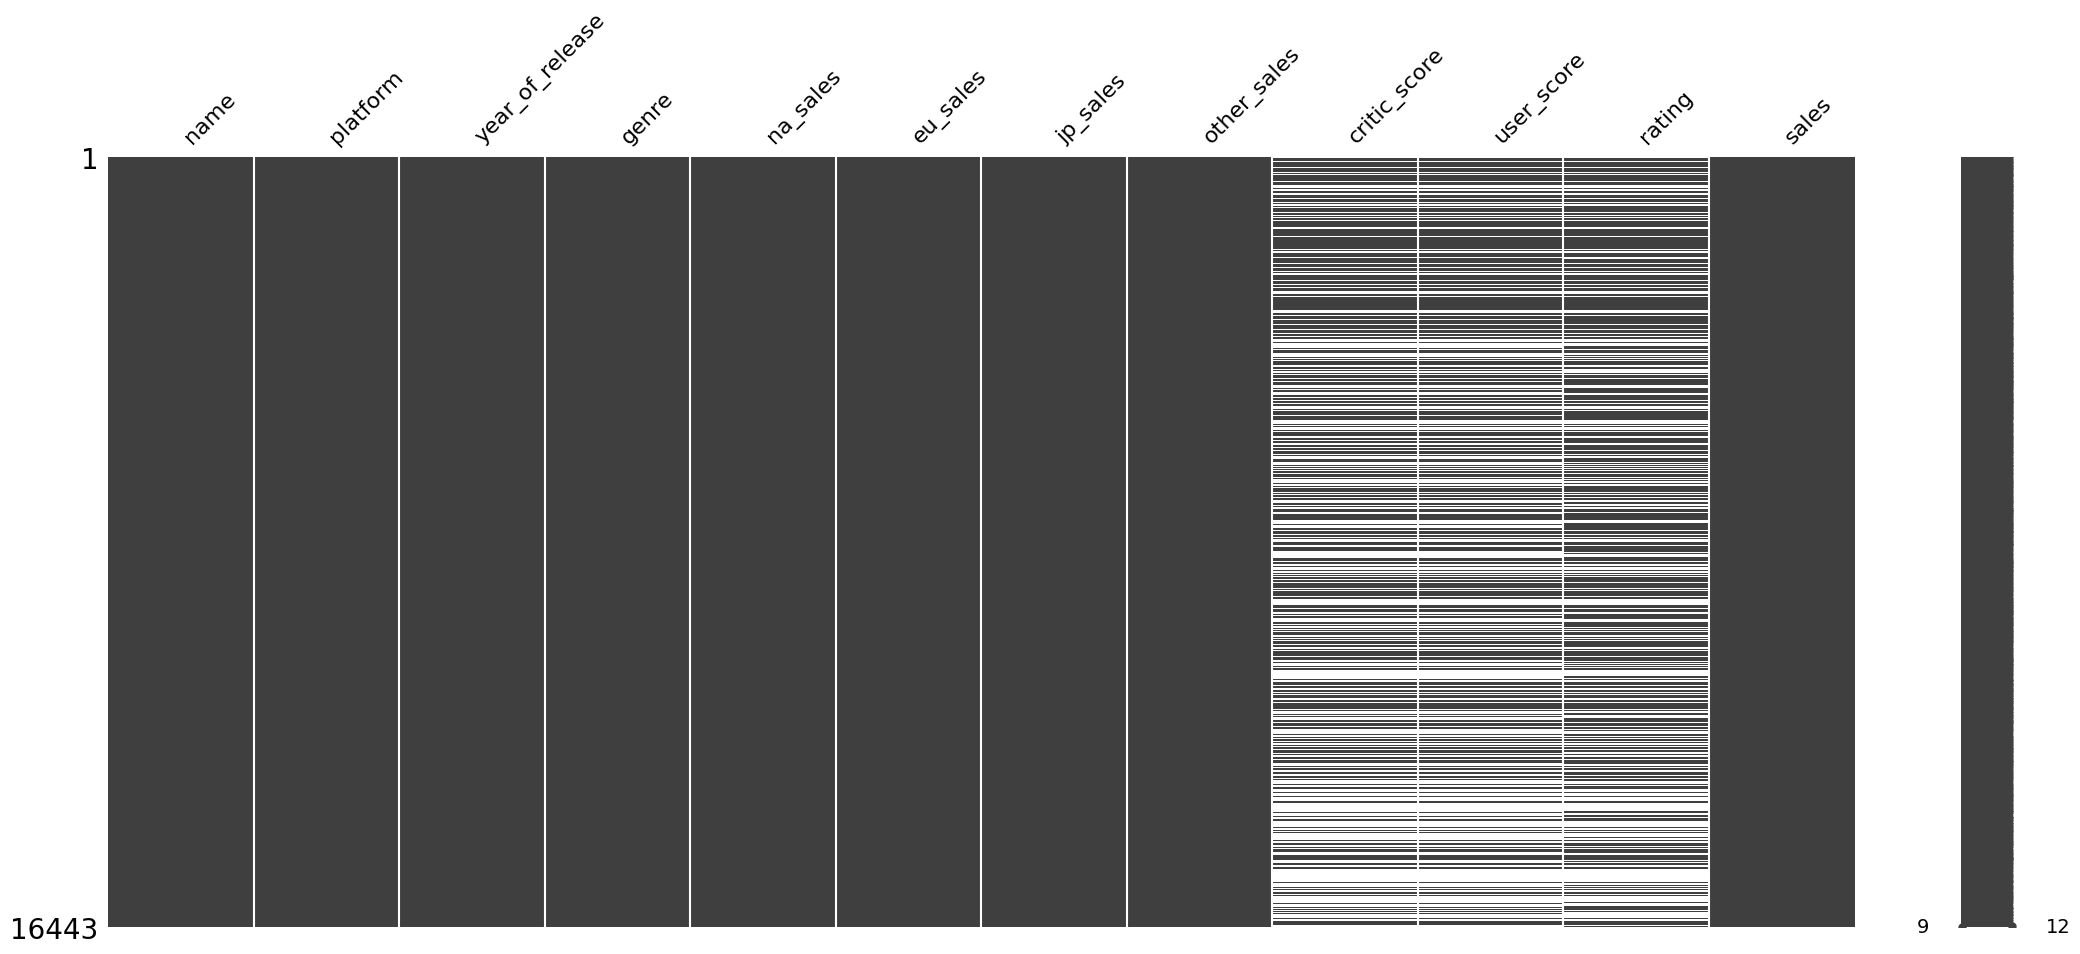

In [17]:
msno.matrix(games)

- Переимновал столбцы на корректные (таблица с колонками ниже)
- Создал новую колонку с общими продажами
- Нормировал `critic_score`
- Обработал пропущенные значения, но некоторые остались (матрица пропусков выше) 
- Привел колонки к корректным типам данных
- Аномальные значения не были выявлены

|Поле           |Тип данных|Описание                                             |
|---------------|----------|-----------------------------------------------------|
|name           |str       |Название игры                                        |
|platform       |str       |Платформа                                            |
|year_of_release|uint16    |Год выпуска                                          |
|genre          |str       |Жанр игры                                            |
|na_sales       |float     |Продажи в Северной Америке (миллионы проданных копий)|
|eu_sales       |float     |Продажи в Европе (миллионы проданных копий)          |
|jp_sales       |float     |Продажи в Японии (миллионы проданных копий)          |
|other_sales    |float     |Продажи в других странах (миллионы проданных копий)  |
|critic_score   |float     |Оценка критиков (максимум 100)                       |
|user_score     |float     |Оценка пользователей (максимум 10)                   |
|rating         |str       |Возрастная категория                                 |
|sales          |float     |Продажи во всем мире (миллионы проданных копий)      |

_____
_____
## Исследовательский анализ данных

_____
#### Функции отрисовки статистических данных.

In [18]:
def statistical_graphis_for_numeric(col: pd.Series, nbinsx=50):
	fig = make_subplots(rows=1, cols=2, subplot_titles=(f'Гистограмма {col.name}', f'Диаграмма размаха {col.name}'))

	fig.add_trace(
		go.Histogram(x=col, nbinsx=nbinsx, marker_color='blue', name=''),
		row=1, col=1
	)
	fig.update_xaxes(title_text=col.name, row=1, col=1)
	fig.update_yaxes(title_text='Частота', row=1, col=1)

	fig.add_trace(
		go.Box(y=col, marker_color='orange', name=''),
		row=1, col=2
	)
	fig.update_yaxes(title_text=col.name, row=1, col=2)

	fig.update_layout(
		title_text=f'Статистический анализ для {col.name}',
		showlegend=False,
		width=1000,
		height=500
	)

	fig.show()


def statistical_graphis_for_categorical(col: pd.Series):
	category_counts = col.value_counts()
	categories = category_counts.index
	counts = category_counts.values

	fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'xy'}, {'type': 'domain'}]],
		subplot_titles=(f'Гистограмма {col.name}', f'Круговая диаграмма {col.name}'))

	fig.add_trace(
		go.Histogram(x=col, marker_color='green', showlegend=False, name=''),
		row=1, col=1
	)
	fig.update_xaxes(title_text=col.name, categoryorder='total ascending', row=1, col=1)
	fig.update_yaxes(title_text='Частота', row=1, col=1)

	fig.add_trace(
		go.Pie(labels=categories, values=counts, name='', textinfo='none'),
		row=1, col=2
	)

	fig.update_layout(
		title_text=f'Статистический анализ для {col.name}',
		showlegend=True,
		width=1000,
		height=500,
	)

	fig.show()

_____
#### Количество игр, выпущенных в разные годы. Важны ли данные за все периоды?

In [19]:
statistical_graphis_for_categorical(games.year_of_release.sort_values())

Все года в итоговой выборке не будут полезны, потому что игры меняются, меняются уровень продаж, поэтому старые игры станут статистических "баластом".

_____
### Продажи каждой платформы. Платформы с наибольшими суммарными продажами и построение распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

In [20]:
games.platform.unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [25]:
platform_sales = games.groupby('platform').sales.sum().sort_values()
go.Figure(go.Bar(
    x=platform_sales.values,
    y=platform_sales.index,
    orientation='h',
    textposition='outside',
    text=platform_sales.values.round(1),
)).update_layout(
    title='Пример горизонтальной столбчатой диаграммы',
    xaxis_title='Значения',
    yaxis_title='Категории',
    height=800,
    width=1200
)

Выберем популярн

In [28]:
pop_platform = platform_sales.tail(5).index
pop_platform

Index(['DS', 'PS3', 'Wii', 'X360', 'PS2'], dtype='object', name='platform')

In [34]:
pop_platform_dist_years = games.query('platform in @ pop_platform').groupby(by=['platform', 'year_of_release']).sales.sum()
pop_platform_dist_years

platform  year_of_release
DS        1985                 0.02
          2004                15.91
          2005               119.34
          2006               111.64
          2007               135.85
          2008               134.37
          2009               110.99
          2010                79.48
          2011                24.30
          2012                10.42
          2013                 1.42
PS2       2000                35.59
          2001               149.65
          2002               183.66
          2003               163.62
          2004               171.96
          2005               141.51
          2006                89.18
          2007                52.30
          2008                34.59
          2009                16.24
          2010                 4.44
          2011                 0.35
PS3       2006                17.30
          2007                62.48
          2008               101.78
          2009               113.08
  

In [43]:
fig = go.Figure()
for platform in pop_platform:
    fig.add_trace(
        go.Line(
            x=pop_platform_dist_years[platform].index,
            y=pop_platform_dist_years[platform],
		)
	)
fig.show()

c:\Users\bezgr\STUDY\DS\Ya-Practicum\.venv\Lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


